In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
etfs = [
    'SPY', 'VGK', 'IEF', 'LQD', 'USO', 'GLD', 'VNQ', 'RWO', 'IWM', 'HYG', 'DBC'
]

adj_close = pd.read_csv('historical_prices.csv', index_col='Date', parse_dates=True)

returns = adj_close.pct_change().dropna()

In [3]:
returns

,SPY,VGK,IEF,LQD,USO,GLD,VNQ,RWO,IWM,HYG,DBC
Date,,,,,,,,,,,
2010-01-05,0.002648,-0.001601,0.004391,0.004776,0.003477,-0.000911,-0.001122,0.004011,-0.003439,0.004745,0.001189
2010-01-06,0.000704,0.006015,-0.004036,-0.002947,0.013858,0.016500,-0.001798,-0.006147,-0.000941,0.002586,0.017808
2010-01-07,0.004222,-0.006377,0.000000,0.001239,-0.006102,-0.006188,0.010806,0.004638,0.007378,0.004037,-0.012442
2010-01-08,0.003327,0.010028,0.001238,0.002190,0.005157,0.004963,-0.007350,-0.001539,0.005454,0.001563,-0.000787
2010-01-11,0.001397,0.007942,0.000674,0.001045,-0.009528,0.013289,0.005834,0.005857,-0.004030,-0.000892,-0.003152
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.005752,0.003246,-0.004527,-0.003073,0.023929,0.002998,0.008901,0.004429,0.004551,0.002561,0.018272
2022-12-27,-0.003944,0.001977,-0.008372,-0.012890,0.003029,0.008430,-0.000362,0.000245,-0.006709,-0.010351,0.008972
2022-12-28,-0.012428,-0.009150,-0.002397,-0.003123,-0.013663,-0.004506,-0.017048,-0.013715,-0.015529,-0.013448,-0.011318


In [4]:
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

In [5]:
def risk_contribution(weights, cov_matrix):
    portfolio_var = portfolio_variance(weights, cov_matrix)
    marginal_contrib = cov_matrix @ weights
    risk_contrib = np.multiply(marginal_contrib, weights) / portfolio_var
    return risk_contrib

In [6]:
def objective_function(weights, cov_matrix):
    risk_contrib = risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contrib)
    return np.sum((risk_contrib - target_risk) ** 2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3913042099776746e-08
            Iterations: 24
            Function evaluations: 306
            Gradient evaluations: 24
Risk Parity Weights:
      Weights
SPY  0.050869
VGK  0.041859
IEF  0.377514
LQD  0.133791
USO  0.033170
GLD  0.083904
VNQ  0.040631
RWO  0.043226
IWM  0.040639
HYG  0.095410
DBC  0.058986


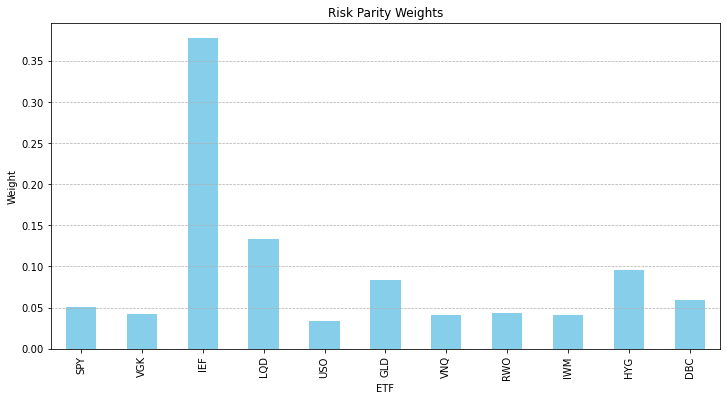

In [7]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

bounds = [(0, 1) for _ in range(len(etfs))]

initial_guess = np.ones(len(etfs)) / len(etfs)

cov_matrix = returns.cov().values

options = {
    'disp': True,   
    'maxiter': 1000,     
}

result = minimize(objective_function, initial_guess, args=(cov_matrix,), constraints=constraints, tol=1e-6, bounds=bounds, options=options)

risk_parity_weights = result.x

risk_parity_weights_df = pd.DataFrame(risk_parity_weights, index=etfs, columns=['Weights'])

print("Risk Parity Weights:")
print(risk_parity_weights_df)

risk_parity_weights_df.plot(kind='bar', legend=False, figsize=(12, 6), color='skyblue')
plt.title('Risk Parity Weights')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.ylabel('Weight')
plt.xlabel('ETF')
plt.show()

In [8]:
import numpy as np

mean_returns = returns.mean()

expected_portfolio_return = np.sum(risk_parity_weights * mean_returns)

portfolio_variance = portfolio_variance(risk_parity_weights, returns.cov().values)

portfolio_risk = np.sqrt(portfolio_variance)

annualized_return = (1 + expected_portfolio_return) ** 252 - 1
annualized_return_percent = annualized_return * 100
print(f"Annualized Expected Portfolio Return: {annualized_return_percent:.2f}%")

annualized_volatility = portfolio_risk * np.sqrt(252)
annualized_volatility_percent = annualized_volatility * 100
print(f"Annualized Portfolio Risk (Volatility): {annualized_volatility_percent:.2f}%")

Annualized Expected Portfolio Return: 4.57%
Annualized Portfolio Risk (Volatility): 6.87%


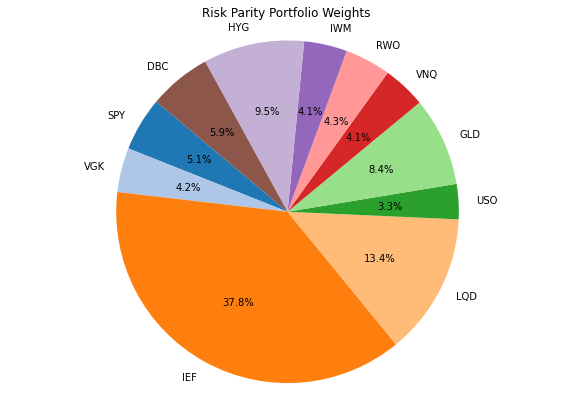

In [9]:
plt.figure(figsize=(10, 7), facecolor='white')
plt.pie(risk_parity_weights, labels=etfs, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Risk Parity Portfolio Weights')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

C:\Users\robby\AppData\Local\Temp/ipykernel_37388/778627500.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in vals])


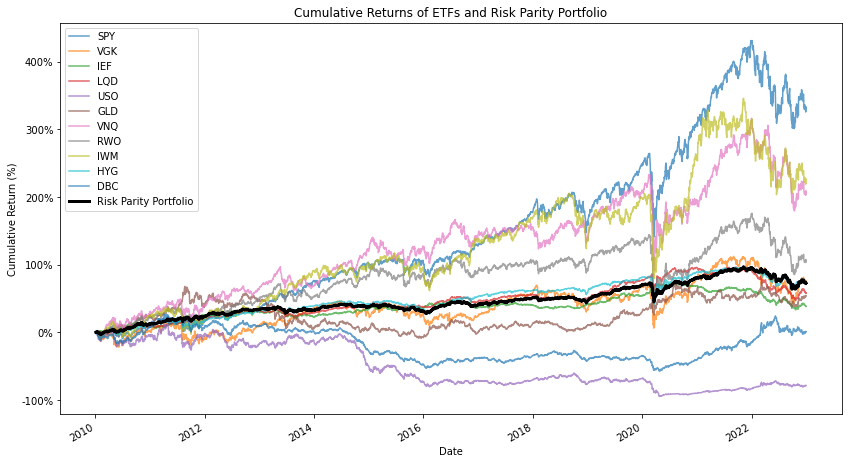

In [10]:
# Calculate cumulative returns of individual ETFs
cumulative_returns = (1 + returns).cumprod() - 1

# Calculate portfolio returns
portfolio_returns = returns.dot(risk_parity_weights)
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1

# Plot cumulative returns in percentage terms
plt.figure(figsize=(14, 8), facecolor='white')
for etf in etfs:
    cumulative_returns[etf].plot(label=etf, alpha=0.7)
cumulative_portfolio_returns.plot(label='Risk Parity Portfolio', linewidth=3, color='black')
plt.title('Cumulative Returns of ETFs and Risk Parity Portfolio')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.legend()

# Adjust the y-axis to show percentage values
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in vals])
plt.show()